## Dynamic Cosmography of the Local Universe


This notebook demonstrates how to visualize cosmic structures in the local Universe, including the Laniakea supercluster and five additional watershed superclusters, inspired by Dupuy et al. (2023). 

The focus here is on constructing high-quality 2D and 3D plots from cosmological data, illustrating overdensities, underdensities, and velocity flows in galaxy distributions.

*ArXiv:2305.02339*

In [132]:
# Setup and import
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pyvista as pv
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u

### Data Overview

For this project, the data includes:

1. **Density and velocity fields**
   - 3D grids of size (128, 128, 128) covering a cubic volume of 1000 Mpc/h per side.
   - `d` : 3D overdensity field.
   - `vx, vy, vz` : components of the 3D peculiar velocity field.
   - Format: FITS files (`.fits`).


> **Note:** The actual datasets are not included for privacy reasons.

In [134]:
# Load density and velocity fields
path = '/Users/adupuy/Documents/RESEARCH/segmentation_cf4/'
fname = 'CF4_new_128-z008'

# Density
hdul = fits.open(path+'cf4_rec/grid128/'+fname+'_delta.fits')
d = hdul[0].data 

# Velocity components
hdul = fits.open(path+'cf4_rec/grid128/'+fname+'_velocity.fits')
vx, vy, vz = hdul[0].data
# For some reason we need to multiply by 52 to get km/s
vx, vy, vz = np.swapaxes(vx*52,0,2), np.swapaxes(vy*52,0,2), np.swapaxes(vz*52,0,2) 

N = vx.shape[1]  # grid size
L = 1000          # box size in Mpc/h
v = np.array([vx, vy, vz]).T

2. **Basins of attraction and repulsion**
   - `centers_a, centers_r`: centers of basins of attraction (attractors) and basins of repulsion (repellers) with coordinates (SGX, SGY, SGZ) in Mpc/h, velocities (VX, VY, VZ) in km/s, and the name of the corresponding large-scale structure.
   - `basins_a, basins_r`: 3D grids of size (128, 128, 128), aligned with the density/velocity fields, and stored in **VTK Image (`.vti`) format**. Each cell contains the **label of the basin** it belongs to:
      - `basins_a` : basins of attraction (BoA), e.g., all cells in the Laniakea basin share the same label.
      - `basins_r` : basins of repulsion (BoR), similarly labeled.

In [ ]:
# Load attractor/repeller coordinates
centers_a = pd.read_csv(f'{path}/cf4_seg/max_coordinates/{fname}_forward_8_attractors.csv',
    sep='|', index_col=0,
    header=0,
    names=['Label','SGX','SGY','SGZ','VX','VY','VZ','NAME']
)
centers_r = pd.read_csv(f'{path}/cf4_seg/max_coordinates/{fname}_backward_8_repellers.csv',
    sep='|', index_col=0,
    header=0,
    names=['Label','SGX','SGY','SGZ','VX','VY','VZ','NAME']
)

# Drop empty names
centers_a = centers_a[centers_a.NAME != ' no']
centers_r = centers_r[centers_r.NAME != ' no']

# Convert supergalactic to ICRS coordinates
for df in [centers_a, centers_r]:
    c = SkyCoord(
        sgx=df.SGX, sgy=df.SGY, sgz=df.SGZ,
        frame='supergalactic', representation_type='cartesian'
    )
    c_icrs = c.transform_to('icrs')
    df['RA'] = c_icrs.ra.degree
    df['DEC'] = c_icrs.dec.degree
    df['Vcmb'] = c_icrs.distance * 100  # km/s, assuming distance in Mpc/h

# Compute volumes of each basin
def compute_volumes(df, basins_grid, L, N):
    """Compute volumes (Mpc^3) for each basin label."""
    volumes = np.zeros(df.shape[0])
    scalar_array = basins_grid.point_data.get_array('Scalars_')
    cell_volume = (L / N) ** 3
    for i, label in enumerate(df.index):
        volumes[i] = np.sum(scalar_array == label) * cell_volume
    df['VOLUME'] = volumes / 1e6  # Convert to 10^6 Mpc^3
    return df

basins_a = pv.read(f'{path}/cf4_seg/basins/{fname}_forward_8_BoA.vti')
basins_a.origin = (-L//2, -L//2, -L//2)
basins_a.spacing = (L/N, L/N, L/N)

info_a = compute_volumes(centers_a, basins_a, L, N)

basins_r = pv.read(f'{path}/cf4_seg/basins/{fname}_backward_8_BoR.vti')
basins_r.origin = (-L//2, -L//2, -L//2)
basins_r.spacing = (L/N, L/N, L/N)

info_r = compute_volumes(centers_r, basins_r, L, N)

# Concatenate BOA and BOR
info_all = pd.concat([info_a, info_r], axis=0)

# Drop unused velocity columns
info_all = info_all.drop(columns=['VX','VY','VZ'])

# Reorder columns
info_all = info_all[['NAME','RA','DEC','Vcmb','SGX','SGY','SGZ','VOLUME']]

# Set NAME as index if desired
info_all = info_all.set_index('NAME')

info_all

,RA,DEC,Vcmb,SGX,SGY,SGZ,VOLUME
NAME,,,,,,,
SDSS-1a,132.571465,23.640600,34116.521955,117.1880,226.5620,-226.5620,184.773445
Lepus,98.980074,-49.460008,13189.017981,-62.5000,-39.0625,-109.3750,8.086681
Apus,198.769640,-74.577576,13096.136417,-125.0000,-23.4375,-31.2500,9.523392
Perseus-Pisces,56.445881,21.023422,6101.757559,46.8750,-23.4375,-31.2500,4.800320
Shapley,199.297413,-39.617699,15467.960838,-140.6250,62.5000,-15.6250,7.910252
Laniakea,262.538518,-38.998576,7411.588266,-62.5000,-7.8125,39.0625,1.945019
Hercules,237.233729,9.048155,11213.046949,-39.0625,70.3125,78.1250,3.144741
SDSS-2a,209.310095,11.767629,32979.455016,-101.5620,296.8750,101.5620,169.764996
SDSS-2b,217.548553,35.822673,33007.190860,31.2500,289.0620,156.2500,130.237579


   - Streamline histograms (`.vti`) show the density of flow lines within the volume.
   - Cosmicflows-4 galaxy catalog: a catalog of observed galaxies with positions and distances, includes:
      - Supergalactic longitude (`SGL`) and latitude (`SGB`) in degrees.
      - Distances in Mpc/h (derived from redshifts, CMB frame).
      - Data is loaded as a `SkyCoord` object in **supergalactic coordinates** and converted to Cartesian coordinates for plotting and analysis.

In [ ]:
# Load more segmentation data
hstream = pv.read(f'{path}/cf4_seg/hstream/'+fname+'_forward_streamlines_histo.vti') \
            .point_data.get_array('Scalars_')

# Load Cosmicflows-4 galaxy catalog
cat = np.genfromtxt(f'{path}/CF4_12dec22.txt', skip_header=5, delimiter=',')
c = SkyCoord(sgl=cat[:,4]*u.degree, sgb=cat[:,5]*u.degree, distance=cat[:,1]/100, frame='supergalactic')
c.representation_type = 'cartesian'

### 3D Visualization: Basins and Streamlines

This plot shows the **basins of attraction** reconstructed from the Cosmicflows-4 data.  
- **Streamlines** are integrated from the velocity field **inside each basin**.  
- **Laniakea**, our home supercluster, is highlighted in a distinct color to emphasize its structure.  
- Other superclusters are shown with lower opacity to provide context without overwhelming the visualization.  

In [ ]:
# ==========================
# Dynamic Cosmography 3D Visualization
# Using PyVista to visualize Cosmicflows-4 density, velocity fields,
# gravitational basins, streamlines, and key superclusters.
# ==========================

# Plotting theme
my_theme = pv.themes.DefaultTheme()
my_theme.color = 'white'
my_theme.background = 'black'
my_theme.font.color = 'white'
pv.global_theme.load_theme(my_theme)

# Initialize Plotter with large window size for high-res screenshots
plotter = pv.Plotter(window_size=[1000, 1000], theme=my_theme)

# Add coordinate arrows
arrowX = pv.Arrow(start=(-200.,-200.,0.), direction=(50.,0.,0.), scale='auto')
arrowY = pv.Arrow(start=(-200.,-200.,0.), direction=(0.,50.,0.), scale='auto')
arrowZ = pv.Arrow(start=(-200.,-200.,0.), direction=(0.,0.,50.), scale='auto')

plotter.add_mesh(arrowX, color='red')
plotter.add_mesh(arrowY, color='green')
plotter.add_mesh(arrowZ, color='blue')

# Create PyVista UniformGrid for scalar/vector data
flow = pv.UniformGrid()
flow.dimensions = d.shape
flow.origin = (-L//2, -L//2, -L//2)
flow.spacing = (L/N, L/N, L/N)
flow.point_data["density"] = d.flatten(order="F")
flow.point_data["velocity"] = v.reshape((N*N*N,3), order="F")
flow.point_data["-density"] = -1. * d.flatten(order="F")

# Ensure basins grid matches
basins_a.origin = (-L//2, -L//2, -L//2)
basins_a.spacing = (L/N, L/N, L/N)
basins_a.point_data["density"] = d.flatten(order="F")
basins_a.point_data["-density"] = -1.*d.flatten(order="F")
basins_a.point_data["velocity"] = v.reshape((N*N*N,3), order="F")

basins_a.point_data["hstream"] = np.log10(hstream)/np.log10(hstream.max())

pts = np.vstack((c.sgx.value, c.sgy.value, c.sgz.value)).T
pset = pv.PointSet(pts)

# Assign individual supercluster basins
label_grid = np.swapaxes(basins_a.point_data.get_array('Scalars_').reshape((N,N,N)),0,2)
labels = centers_a.index.values

for label in labels:
    one_basin = np.ones((N,N,N))
    one_basin[label_grid!=label] = 0.
    basins_a.point_data[centers_a.NAME.loc[label]] = one_basin.flatten(order="F")

# Probe the basins at galaxy points
probe = basins_a.probe(points=pts)

# Add superclusters and streamlines to plotter
hmin, hmax = 0., 0.5
cmap_main = matplotlib.colormaps['YlOrRd_r']
cmap_side = matplotlib.colormaps['Purples_r']

for struct in centers_a.NAME:
    opacity = 0.4 if 'Laniakea' in struct else 0.1
    cmap = cmap_main if 'Laniakea' in struct else cmap_side
    in_basin = probe.threshold(scalars=struct, value=1.)
    plotter.add_mesh(in_basin, style='points', point_size=2, opacity=opacity,
                     scalars='hstream', cmap=cmap, clim=[hmin,hmax], show_scalar_bar=False)
    
    # Streamlines from each basin
    stream = basins_a.streamlines_from_source(
        source=in_basin,
        vectors='Vectors_',
        integrator_type=4,
        integration_direction='forward',
        max_time=500,
        initial_step_length=0.5
    )
    plotter.add_mesh(stream, opacity=opacity, scalars='hstream', cmap=cmap, clim=[hmin,hmax],
                     show_scalar_bar=False)

# Add supercluster labels
points = centers_a[['SGX','SGY','SGZ']] + L/N/2
pset = pv.PointSet(points)
plotter.add_point_labels(points=pset, labels=centers_a.NAME,
                         font_size=16, shape=None, text_color='white', bold=True,
                         font_family='arial', point_color='white', show_points=False,
                         tolerance=1e60)

# Camera & render
plotter.camera_position = [
    (504.2, 60.6, 1058.3),   # camera location
    (37.2, 99.2, 46.7),      # focal point
    (0.021, 0.999, 0.028)    # view up vector
]

plotter.show()
plotter.screenshot('visu3d.png', transparent_background=False);

 SDSS-1a
 Lepus
 Apus
 Perseus-Pisces
 Shapley
 Laniakea
 Hercules
 SDSS-2a
 SDSS-2b
      !!!No serializer for vtkActor2D with id 00007fee8cf69880
      !!!No serializer for vtkActor2D with id 00007fee8cf69880
      !!!No serializer for vtkActor2D with id 00007fee8cf69880
      !!!No serializer for vtkActor2D with id 00007fee8cf69880


Widget(value="<iframe src='http://localhost:50945/index.html?ui=P_0x7ff0c33fbd60_44&reconnect=auto' style='wid…

### 3D Visualization: Density Isosurfaces and Streamlines

This figure combines **density isosurfaces** with **velocity streamlines** to illustrate the local cosmic structure:

- **Density field**: shown as semi-transparent isosurfaces at multiple levels, highlighting regions of high and low galaxy/DM density.
- **Basins of attraction**: streamlines are integrated from the velocity field **inside each basin**, revealing the direction of cosmic flows toward attractors.
- **Attractor centers**: visualized as spheres, indicating the central locations of superclusters.
- Streamlines are colored uniformly, and density levels provide context for the flows without obscuring the basin structure.

> Note: Streamlines are only traced inside the basins; this plot emphasizes the interplay between density structures and cosmic flows toward superclusters.

In [ ]:
# ==========================
# 3D Visualization of Cosmicflows Basins with Streamlines
# ==========================

# Define plotting theme
my_theme = pv.themes.DefaultTheme()
my_theme.color = 'black'          # primary text color
my_theme.background = 'white'     # background of render
my_theme.font.color = 'black'
pv.global_theme.load_theme(my_theme)

# Initialize plotter with a border for portfolio screenshots
plotter = pv.Plotter(
    window_size=[1000, 1000],
    theme=my_theme,
    border=True,
    border_color='black',
    border_width=10
)

# Add 3D coordinate arrows
arrowX = pv.Arrow(start=(0.,0.,0.), direction=(50.,0.,0.), scale='auto')
arrowY = pv.Arrow(start=(0.,0.,0.), direction=(0.,50.,0.), scale='auto')
arrowZ = pv.Arrow(start=(0.,0.,0.), direction=(0.,0.,50.), scale='auto')

plotter.add_mesh(arrowX, color='red')
plotter.add_mesh(arrowY, color='green')
plotter.add_mesh(arrowZ, color='blue')

# Create uniform grid for density & velocity fields
flow = pv.UniformGrid(
    dimensions=(N, N, N),
    origin=(-L//2 + L/N/2, -L//2 + L/N/2, -L//2 + L/N/2),
    spacing=(L/N, L/N, L/N)
)
flow.point_data["density"] = d.flatten(order="F")
flow.point_data["velocity"] = v.reshape((N*N*N, 3), order="F")
flow.point_data["-density"] = -1. * d.flatten(order="F")

# Function to show a single basin with streamlines
def show_basin(label, basins, direction, downsample, color):
    """
    Visualize a basin as streamlines starting from points in the basin.
    
    Parameters:
        label: int, basin label to visualize
        basins: PyVista grid of basins
        direction: 'forward' or 'backward' for integration
        downsample: int, take every n-th point to reduce number of streamlines
        color: str, color of streamlines
    """
    # Get the 3D grid of basin labels
    basins_grid = np.swapaxes(
        basins.point_data.get_array('Scalars_').reshape((N, N, N)),
        0, 2
    )
    # Get coordinates of points belonging to this basin
    start_coords = np.where(basins_grid == label)
    nstream = int(np.round(start_coords[0].shape[0] / downsample))
    
    # Construct starting points for streamlines
    start_pts = np.vstack([
        start_coords[0][::nstream] * L/N - L/2,
        start_coords[1][::nstream] * L/N - L/2,
        start_coords[2][::nstream] * L/N - L/2
    ]).T
    start_pts += L/N/2  # center in cell
    start_arr = pv.wrap(start_pts)
    
    # Generate streamlines
    stream = basins.streamlines_from_source(
        source=start_arr,
        vectors='Vectors_',
        integrator_type=4,
        integration_direction=direction,
        max_time=500,
        initial_step_length=1.0
    )
    
    # Add streamlines as tubes for visualization
    plotter.add_mesh(stream.tube(radius=0.2), opacity=0.2, color=color)

# Prepare basins grid
basins_a.origin = (-L//2 + L/N/2, -L//2 + L/N/2, -L//2 + L/N/2)
basins_a.spacing = (L/N, L/N, L/N)

# Add density isosurfaces
dvals = np.linspace(0.75,1.75,4) # 4 levels
norm = matplotlib.colors.Normalize(vmin=dvals.min(), vmax=dvals.max())
cmap = matplotlib.colormaps['Reds']  # Matplotlib 3.7+ compatible
dcols = cmap(norm(dvals))

for i, dval in enumerate(dvals):
    iso = flow.contour(isosurfaces=(dval,), scalars='density')
    plotter.add_mesh(
        iso,
        color=dcols[i],
        opacity=0.75,
        smooth_shading=True,
        use_transparency=True
    )

# Visualize all labeled basins with streamlines
stream_color = 'black'
for i, label in enumerate(labels):
    # SDSS labels need denser sampling for visibility
    downsample = 50 if 'SDSS' in centers_a.loc[label]['NAME'] else 200
    show_basin(label, basins_a, direction='forward', downsample=downsample, color=stream_color)

# Add supercluster labels as points with text
points = centers_a.loc[labels][['SGX','SGY','SGZ']] + L/N/2
pset = pv.PointSet(points)
plotter.add_point_labels(
    points=pset,
    labels=centers_a.loc[labels]['NAME'],
    font_size=20,
    shape=None,
    text_color=stream_color,
    bold=True,
    font_family='arial',
    point_color=stream_color,
    show_points=True,
    point_size=20,
    render_points_as_spheres=True,
    tolerance=1e50
)

# Camera and rendering
plotter.camera_position = [
    (520.59, -170.16, 1151.14),  # camera position
    (22.87, 67.71, -4.10),       # focal point
    (0.071, 0.983, 0.172)        # view-up vector
]

# Display plot and save screenshot
plotter.show()
plotter.screenshot('visu3d_2.png');

      !!!No serializer for vtkActor2D with id 00007feb4d841da0
      !!!No serializer for vtkActor2D with id 00007feb4d893120
      !!!No serializer for vtkActor2D with id 00007feb4d8482e0
      !!!No serializer for vtkActor2D with id 00007feb4d841da0
      !!!No serializer for vtkActor2D with id 00007feb4d893120
      !!!No serializer for vtkActor2D with id 00007feb4d8482e0
      !!!No serializer for vtkActor2D with id 00007feb4d841da0
      !!!No serializer for vtkActor2D with id 00007feb4d893120
      !!!No serializer for vtkActor2D with id 00007feb4d8482e0
      !!!No serializer for vtkActor2D with id 00007feb4d841da0
      !!!No serializer for vtkActor2D with id 00007feb4d893120
      !!!No serializer for vtkActor2D with id 00007feb4d8482e0


Widget(value="<iframe src='http://localhost:50945/index.html?ui=P_0x7ff35540c220_39&reconnect=auto' style='wid…

### 2D Mid-Plane Slice of Streamline Density

This figure shows a **2D slice of the streamline density** (mid-plane, z = N/2) derived from the Cosmicflows-4 velocity field:

- **Streamline density**: color-coded using a logarithmic scale, highlighting regions where cosmic flows converge (high-density flows) and underdense regions.
- **Major superclusters**: annotated on the plot (e.g., Laniakea, Shapley, Coma), showing how flow concentrations correspond to known large-scale structures.

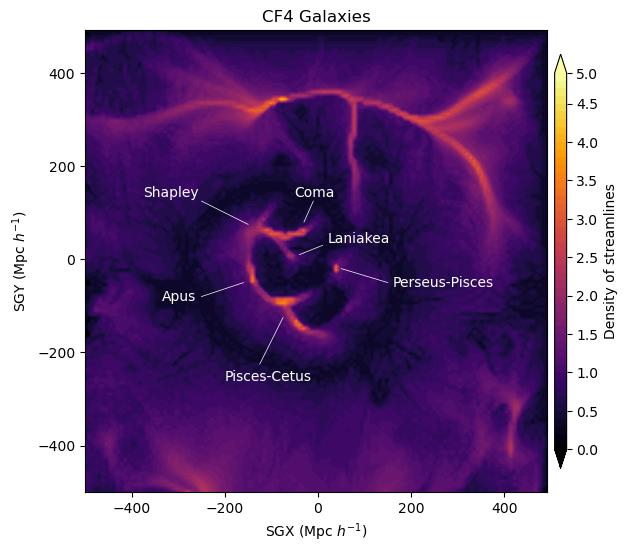

In [97]:
# ==========================
# 2D Mid-plane Visualization of Streamline Density
# ==========================

axes = np.arange(N) * L/N - L/2 # axes coordinates in supergalactic space (Mpc/h)

h = np.log10(hstream.reshape((N, N, N))) # Compute logarithm of streamline histogram (hstream)

fig, ax = plt.subplots(1, 1, figsize=(6, 6))

# Contour plot of mid-plane (z = N//2)
im = ax.contourf(
    axes, axes, h[N//2, :, :],  # mid-plane slice
    cmap='inferno',             # colormap
    levels=np.arange(0, 5, 0.1),
    extend='both'
)

# Set axis limits and labels
ax.set_xlim(axes[0], axes[-1])
ax.set_ylim(axes[0], axes[-1])
ax.set_xlabel('SGX (Mpc $h^{-1}$)')
ax.set_ylabel('SGY (Mpc $h^{-1}$)')
ax.set_aspect('equal')  # equal aspect ratio
ax.set_title('CF4 Galaxies')

# Annotate major superclusters: each line connects a label to its position
annotations = [
    {'line': [[-150,-250],[75,125]], 'text': 'Shapley', 'text_pos': (-375, 135)},
    {'line': [[-30,-10],[80,125]], 'text': 'Coma', 'text_pos': (-50, 135)},
    {'line': [[-40,10],[10,30]], 'text': 'Laniakea', 'text_pos': (20, 35)},
    {'line': [[-160,-250],[-50,-80]], 'text': 'Apus', 'text_pos': (-335, -90)},
    {'line': [[-75,-125],[-125,-225]], 'text': 'Pisces-Cetus', 'text_pos': (-200, -260)},
    {'line': [[50,150],[-20,-50]], 'text': 'Perseus-Pisces', 'text_pos': (160, -60)},
]

for ann in annotations:
    xline, yline = ann['line']
    ax.plot(xline, yline, color='white', lw=0.5)
    ax.text(*ann['text_pos'], s=ann['text'], color='white', fontsize=10)

# Add colorbar 
cbar_ax = fig.add_axes([0.91, 0.15, 0.02, 0.69])
cbar = fig.colorbar(im, cax=cbar_ax, ticks=np.arange(0, 5.1, 0.5))
cbar.set_label('Density of streamlines')

plt.subplots_adjust(wspace=0)